In [1]:
!pip install cdflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 1.1 MB/s eta 0:00:00


In [2]:
import os
import cdflib
import datetime
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# SELECT WHICH PROFILES TO COMPARE
def nearest_time(satellite, hr):
  '''Inputs: satellite = 1-6
             hr = '00'-'23'
     Output: arrays of profile filenames'''

  folderpath = f'/content/gdrive/MyDrive/msci_satellite_data/cosmic/.ionPrf_postProc_2008_175/23sat{satellite}'
  folder = os.fsencode(folderpath)
  filenames = []
  for file in os.listdir(folder):
      filename = os.fsdecode(file)
      filenames.append(filename)
  filenames.sort()

  profiles_60 = []
  profiles_00_20 = []
  profiles_21_40 = []
  profiles_41_60 = []
  for i in filenames:
      ds = xr.open_dataset(folderpath + '/' + f'{i}')
      gps_seconds = ds.bottime
      gps_epoch = datetime.datetime(1980, 1, 6)
      delta = datetime.timedelta(seconds=gps_seconds) # Convert GPS seconds to timedelta
      utc_time = gps_epoch + delta # Calculate the UTC time
      if utc_time.hour == int(hr):
        profiles_60.append(folderpath + '/' + f'{i}')
      if utc_time.hour == int(hr) and utc_time.minute <= 20:
        profiles_00_20.append(folderpath + '/' + f'{i}')
      if utc_time.hour == int(hr) and 21 <= utc_time.minute <= 40:
        profiles_21_40.append(folderpath + '/' + f'{i}')
      if utc_time.hour == int(hr) and 41 <= utc_time.minute <= 59:
        profiles_41_60.append(folderpath + '/' + f'{i}')

  return profiles_60, profiles_00_20, profiles_21_40, profiles_41_60

In [4]:
# CONTROL MODEL
def extract(ds, time_index, Ztype):
  '''Input a xarray-opened dataset, time index and either Z or ZG in string format.'''
  latitude = ds.lat.values
  longitude = ds.lon.values
  if Ztype == 'Z':
    altitude = ds.Z.values[time_index,:,:,:]
  if Ztype == 'ZG':
    altitude = ds.ZG.values[time_index,:,:,:]
  density = ds.DEN.values[time_index,:,:,:]
  electron_density = ds.NE.values[time_index,:,:,:]
  return latitude, longitude, altitude, density, electron_density

def nasa(hour):
  ds3 = xr.open_dataset('/content/gdrive/MyDrive/msci_satellite_data/nasa/s003.nc') # 00:00 (23rd)
  ds4 = xr.open_dataset('/content/gdrive/MyDrive/msci_satellite_data/nasa/s004.nc') # 00:20 - 08:00
  ds5 = xr.open_dataset('/content/gdrive/MyDrive/msci_satellite_data/nasa/s005.nc') # 08:20 - 16:00
  ds6 = xr.open_dataset('/content/gdrive/MyDrive/msci_satellite_data/nasa/s006.nc') # 16:20 - 00:00 (24th)

  # Due to the irregular organisation for hours 00, 08, 16, their arrays need to be defined specially
  if hour == '00':
    lat1, lon1, ZG1, DEN1, NE1 = extract(ds3, -1, 'ZG')
    lat2, lon2, ZG2, DEN2, NE2 = extract(ds4, 0, 'ZG')
    lat3, lon3, ZG3, DEN3, NE3 = extract(ds4, 1, 'ZG')
  if hour == '08':
    lat1, lon1, ZG1, DEN1, NE1 = extract(ds4, -1, 'ZG')
    lat2, lon2, ZG2, DEN2, NE2 = extract(ds5, 0, 'ZG')
    lat3, lon3, ZG3, DEN3, NE3 = extract(ds5, 1, 'ZG')
  if hour == '16':
    lat1, lon1, ZG1, DEN1, NE1 = extract(ds5, -1, 'ZG')
    lat2, lon2, ZG2, DEN2, NE2 = extract(ds6, 0, 'ZG')
    lat3, lon3, ZG3, DEN3, NE3 = extract(ds6, 1, 'ZG')

  # For the rest of hours:
  if 1 <= int(hour) <= 7:
    time_index = 2*(int(hour)) - 1
    lat1, lon1, ZG1, DEN1, NE1 = extract(ds4, time_index, 'ZG')
    lat2, lon2, ZG2, DEN2, NE2 = extract(ds4, time_index+1, 'ZG')
    lat3, lon3, ZG3, DEN3, NE3 = extract(ds4, time_index+2, 'ZG')
  if 9 <= int(hour) <= 15:
    hour_mapping = [('09', 2), ('10', 5), ('11', 8), ('12', 11), ('13', 14), ('14', 17), ('15', 20)]
    for h, time_index in hour_mapping:
        if hour == h:
          lat1, lon1, ZG1, DEN1, NE1 = extract(ds5, time_index, 'ZG')
          lat2, lon2, ZG2, DEN2, NE2 = extract(ds5, time_index+1, 'ZG')
          lat3, lon3, ZG3, DEN3, NE3 = extract(ds5, time_index+2, 'ZG')
          break
  if 17 <= int(hour) <= 23:
    hour_mapping = [('17', 2), ('18', 5), ('19', 8), ('20', 11), ('21', 14), ('22', 17), ('23', 20)]
    for h, time_index in hour_mapping:
        if hour == h:
          lat1, lon1, ZG1, DEN1, NE1 = extract(ds6, time_index, 'ZG')
          lat2, lon2, ZG2, DEN2, NE2 = extract(ds6, time_index+1, 'ZG')
          lat3, lon3, ZG3, DEN3, NE3 = extract(ds6, time_index+2, 'ZG')
          break

  return lat1, lon1, ZG1, DEN1, NE1, lat2, lon2, ZG2, DEN2, NE2, lat3, lon3, ZG3, DEN3, NE3

In [5]:
nasa('09')[3].shape

(29, 36, 72)

In [6]:
# COMPARISON AND PLOTTING
def interpolate(satellite, time, cosmic, lat, lon, ZG, NE, show_plots):
  # Since the altitude of a given pressure level can vary up to 20km latitudinally, we define the grid through the satellite passed
  # so that we pick an altitude within this range, guaranteeing that the COSMIC-1 satellite will be at the specified pressure level
  satlatmin = min(cosmic.GEO_lat.values) # These four numbers define the latitude/longitude grid that COSMIC-1's trajectory lies in
  satlatmax = max(cosmic.GEO_lat.values)
  satlonmin = min(cosmic.GEO_lon.values)
  satlonmax = max(cosmic.GEO_lon.values)
  modlat = [] # These arrays will contain two indices each which define the TIEGCM latitude/longitude grid which will contain the COSMIC-1 grid
  modlon = []
  for idx, i in enumerate(lat):
      if i >= satlatmin:
          modlat.append(max(0, idx-2))
          break
      else:
        modlat.append(0)
        break
  for idx, i in enumerate(lat):
      if i >= satlatmax:
          modlat.append(min(35, idx+2))
          break
      else:
        modlat.append(35)
        break
  for idx, i in enumerate(lon):
      if i >= satlonmin:
          modlon.append(max(0, idx-2))
          break
  for idx, i in enumerate(lon):
      if i >= satlonmax:
          modlon.append(min(71, idx+2))
          break
      else:
        modlon.append(71)
        break

  model_heights = []
  for i in np.arange(0,29,1):
      model_heights.append(np.min(ZG[i,modlat[0]:modlat[1],modlon[0]:modlon[1]])/100000)

  index = []
  for j in model_heights:
      for idx, i in enumerate(cosmic.MSL_alt.values):
          if i > j:
            index.append(idx)
            break

  values = []
  for i in index:
      values.append(cosmic.MSL_alt.values[i])

  print(f'Distance to nearest available heights in km: {np.array(values) - np.array(model_heights)}')

  latlon = []
  for i in index:
      tuples = (max(min(cosmic.GEO_lat.values[i], 87.5), -87.5), max(min(cosmic.GEO_lon.values[i], 175), -180))
      latlon.append(tuples)

  my_new_tiegcm = []
  for i in np.arange(0,29,1):
      interp0 = RegularGridInterpolator((lat, lon), NE[i,:,:], method='linear')
      my_new_tiegcm.append(interp0(latlon[i]))

  # Find peak heights and densities
  for idxj, j in enumerate(cosmic.MSL_alt.values):
      if j > 100:
        low_index1 = idxj
        break
  for idxk, k in enumerate(cosmic.MSL_alt.values):
      if k > 550:
        high_index1 = idxk-1
        break
  Ne_satpeak = max(cosmic.ELEC_dens.values[low_index1:high_index1])
  for idx, i in enumerate(cosmic.ELEC_dens.values[low_index1:high_index1]):
    if i == Ne_satpeak:
      index1 = idx
  hm_satpeak = cosmic.MSL_alt.values[low_index1:high_index1][index1]

  Ne_modpeak = max(my_new_tiegcm)
  for idx, i in enumerate(my_new_tiegcm):
    if i == Ne_modpeak:
      index2 = idx
  model_heights = model_heights
  hm_modpeak = model_heights[index2]

  gps_seconds = cosmic.bottime
  gps_epoch = datetime.datetime(1980, 1, 6)
  delta = datetime.timedelta(seconds=gps_seconds) # Convert GPS seconds to timedelta
  utc_time = gps_epoch + delta # Calculate the UTC time
  # Plot the electron density profiles
  if show_plots == 1:
    plt.figure(figsize=(14,7))
    plt.plot(cosmic.ELEC_dens.values, cosmic.MSL_alt.values, label=f'COSMIC-1 satellite {satellite} at {utc_time.hour}:{utc_time.minute}:{int(utc_time.second)}')
    plt.plot(my_new_tiegcm, model_heights, 'g', label='TIEGCM')
    plt.xlabel('Electron density / cm^-3')
    plt.ylabel('Altitude / km')
    plt.legend()
    plt.ylim(50,550)
    plt.grid(True)
    plt.title(f'Electron density vs altitude at UT{time} on 23 June 2008')
    plt.show()

  return utc_time, Ne_satpeak, hm_satpeak, Ne_modpeak, hm_modpeak

In [7]:
def comparison(tiegcm, satellite, time, show_plots):
  '''INPUTS: tiegcm = 'control', 'ose'
             satellite = 1-6 (which COSMIC-1 satellite)
             time = '00'-'23'
             show_plots = 0, 1 (no or yes)

     OUTPUTS: electron density profile for TIEGCM vs COSMIC-1 at specified time'''

  if tiegcm=='control':
    latA, lonA, ZGA, DENA, NEA, latB, lonB, ZGB, DENB, NEB, latC, lonC, ZGC, DENC, NEC = nasa(time)
  if tiegcm=='ose':
    ds = xr.open_dataset('/content/gdrive/MyDrive/msci_satellite_data/matsuo_tiegcm_ose/tiegcm_s_ensmean.nc.'+f'{time}')
    if time=='00':
      lat, lon, ZG, DEN, NE = extract(ds, 16, 'Z')
    else:
      lat, lon, ZG, DEN, NE = extract(ds, 1, 'Z')

  profiles_60, profiles_00_20, profiles_21_40, profiles_41_60 = nearest_time(satellite, time)

  profiles = []
  profiles1 = []
  profiles2 = []
  profiles3 = []
  if tiegcm == 'ose':
    for i in profiles_60:
        ds1 = xr.open_dataset(i)
        for idxj, j in enumerate(ds1.MSL_alt.values):
            if j > 100:
              low_index = idxj
              break
        for idxk, k in enumerate(ds1.MSL_alt.values):
            if k > 550:
              high_index = idxk-1
              break
        if (ds1.ELEC_dens.values[low_index:high_index]<0).any():
          continue
        profiles.append(i)

  if tiegcm == 'control':
    for i in profiles_00_20:
        ds1 = xr.open_dataset(i)
        for idxj, j in enumerate(ds1.MSL_alt.values):
            if j > 100:
              low_index = idxj
              break
        for idxk, k in enumerate(ds1.MSL_alt.values):
            if k > 550:
              high_index = idxk-1
              break
        if (ds1.ELEC_dens.values[low_index:high_index]<0).any():
          continue
        profiles1.append(i)

    for i in profiles_21_40:
        ds1 = xr.open_dataset(i)
        for idxj, j in enumerate(ds1.MSL_alt.values):
            if j > 100:
              low_index = idxj
              break
        for idxk, k in enumerate(ds1.MSL_alt.values):
            if k > 550:
              high_index = idxk-1
              break
        if (ds1.ELEC_dens.values[low_index:high_index]<0).any():
          continue
        profiles2.append(i)

    for i in profiles_41_60:
        ds1 = xr.open_dataset(i)
        for idxj, j in enumerate(ds1.MSL_alt.values):
            if j > 100:
              low_index = idxj
              break
        for idxk, k in enumerate(ds1.MSL_alt.values):
            if k > 550:
              high_index = idxk-1
              break
        if (ds1.ELEC_dens.values[low_index:high_index]<0).any():
          continue
        profiles3.append(i)

  time_series = []
  Ne_satpeaks = []
  hm_satpeaks = []
  Ne_modpeaks = []
  hm_modpeaks = []

  if tiegcm == 'ose':
    for cosmic_filepath in profiles:
        cosmic = xr.open_dataset(cosmic_filepath)
        utc_time, Ne_satpeak, hm_satpeak, Ne_modpeak, hm_modpeak = interpolate(satellite, time, cosmic, lat, lon, ZG, NE, show_plots)
        time_series.append(utc_time)
        Ne_satpeaks.append(Ne_satpeak)
        hm_satpeaks.append(hm_satpeak)
        Ne_modpeaks.append(Ne_modpeak)
        hm_modpeaks.append(hm_modpeak)
  if tiegcm == 'control':
    for cosmic_filepath in profiles1:
        cosmic = xr.open_dataset(cosmic_filepath)
        utc_time1, Ne_satpeak1, hm_satpeak1, Ne_modpeak1, hm_modpeak1 = interpolate(satellite, time, cosmic, latA, lonA, ZGA, NEA, show_plots)
        time_series.append(utc_time1)
        Ne_satpeaks.append(Ne_satpeak1)
        hm_satpeaks.append(hm_satpeak1)
        Ne_modpeaks.append(Ne_modpeak1)
        hm_modpeaks.append(hm_modpeak1)
    for cosmic_filepath in profiles2:
        cosmic = xr.open_dataset(cosmic_filepath)
        utc_time2, Ne_satpeak2, hm_satpeak2, Ne_modpeak2, hm_modpeak2 = interpolate(satellite, time, cosmic, latB, lonB, ZGB, NEB, show_plots)
        time_series.append(utc_time2)
        Ne_satpeaks.append(Ne_satpeak2)
        hm_satpeaks.append(hm_satpeak2)
        Ne_modpeaks.append(Ne_modpeak2)
        hm_modpeaks.append(hm_modpeak2)
    for cosmic_filepath in profiles3:
        cosmic = xr.open_dataset(cosmic_filepath)
        utc_time3, Ne_satpeak3, hm_satpeak3, Ne_modpeak3, hm_modpeak3 = interpolate(satellite, time, cosmic, latC, lonC, ZGC, NEC, show_plots)
        time_series.append(utc_time3)
        Ne_satpeaks.append(Ne_satpeak3)
        hm_satpeaks.append(hm_satpeak3)
        Ne_modpeaks.append(Ne_modpeak3)
        hm_modpeaks.append(hm_modpeak3)

  return time_series, Ne_satpeaks, hm_satpeaks, Ne_modpeaks, hm_modpeaks

In [8]:
#time_series, Ne_satpeaks, hm_satpeaks, Ne_modpeaks, hm_modpeaks = comparison('control', 1, '09', 1)

In [9]:
#time_series

In [10]:
# PREPARING ARRAYS FOR PLOTTING
def plot_prep(satellite, offset_corrected, show_plots):
  '''For a given satellite, this function will make the seven arrays to be plotted: time on x-axis, COSMIC NE, CONTROL NE, OSE NE on y-axis, COSMIC HM, CONTROL HM, OSE HM on another y-axis.
  Additions: compute root mean square error for each hour, offset_corrected = 0 or 1.'''
  time = []
  cosmic_ne = []
  control_ne = []
  ose_ne = []
  cosmic_hm = []
  control_hm = []
  ose_hm = []

  RMSE_control_ne = []
  RMSE_ose_ne = []
  RMSE_control_hm = []
  RMSE_ose_hm = []

  # Prepare hours array
  hours = []
  for i in np.arange(0,24,1):
      if i < 10:
        hours.append(f'0{i}')
      else:
        hours.append(f'{i}')

  # Run for loop
  for i in hours:
      time_series1, Ne_satpeaks1, hm_satpeaks1, Ne_modpeaks1, hm_modpeaks1 = comparison('ose', satellite, i, show_plots)
      time_series2, Ne_satpeaks2, hm_satpeaks2, Ne_modpeaks2, hm_modpeaks2 = comparison('control', satellite, i, show_plots)
      if i == '00':
        if offset_corrected == 1:
          offset_ne = np.array(Ne_modpeaks2)[0] - np.array(Ne_modpeaks1)[0]
          offset_hm = np.array(hm_modpeaks2)[0] - np.array(hm_modpeaks1) [0]
        elif offset_corrected == 0:
          offset_ne = 0
          offset_hm = 0
      for j in time_series1:
          time.append(j)
      for k in Ne_satpeaks1:
          cosmic_ne.append(k)
      for m in Ne_modpeaks2:
          control_ne.append(m)
      for n in Ne_modpeaks1:
          ose_ne.append(n)
      for p in hm_satpeaks1:
          cosmic_hm.append(p)
      for q in hm_modpeaks2:
          control_hm.append(q)
      for r in hm_modpeaks1:
          ose_hm.append(r)
      RMSE_control_ne.append(np.sqrt(np.mean(((np.array(Ne_modpeaks2)-offset_ne) - np.array(Ne_satpeaks1))**2)))
      RMSE_ose_ne.append(np.sqrt(np.mean((np.array(Ne_modpeaks1) - np.array(Ne_satpeaks1))**2)))
      RMSE_control_hm.append(np.sqrt(np.mean(((np.array(hm_modpeaks2)-offset_hm) - np.array(hm_satpeaks1))**2)))
      RMSE_ose_hm.append(np.sqrt(np.mean((np.array(hm_modpeaks1) - np.array(hm_satpeaks1))**2)))
      print(i)

  return time, cosmic_ne, control_ne, ose_ne, cosmic_hm, control_hm, ose_hm, RMSE_control_ne, RMSE_ose_ne, RMSE_control_hm, RMSE_ose_hm

In [ ]:
# PLOTTING
time, cosmic_ne, control_ne, ose_ne, cosmic_hm, control_hm, ose_hm, RMSE_control_ne, RMSE_ose_ne, RMSE_control_hm, RMSE_ose_hm = plot_prep(6, 1, 0) # satellite 1

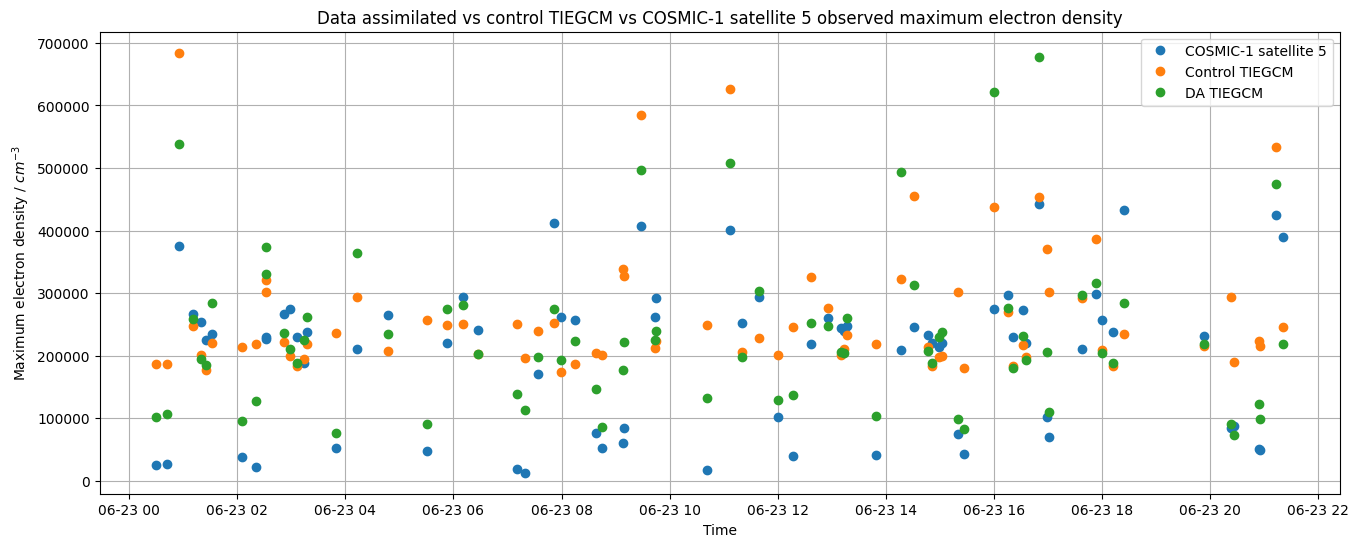

In [46]:
plt.figure(figsize=(16,6))
plt.plot(time, cosmic_ne, 'o', label='COSMIC-1 satellite 5') # satellite 1
plt.plot(time, control_ne, 'o', label='Control TIEGCM')
plt.plot(time, ose_ne, 'o', label='DA TIEGCM')
plt.xlabel('Time')
plt.ylabel('Maximum electron density / $cm^{-3}$')
plt.title('Data assimilated vs control TIEGCM vs COSMIC-1 satellite 5 observed maximum electron density')
plt.legend()
plt.grid(True)
plt.show()

84455.87917259734


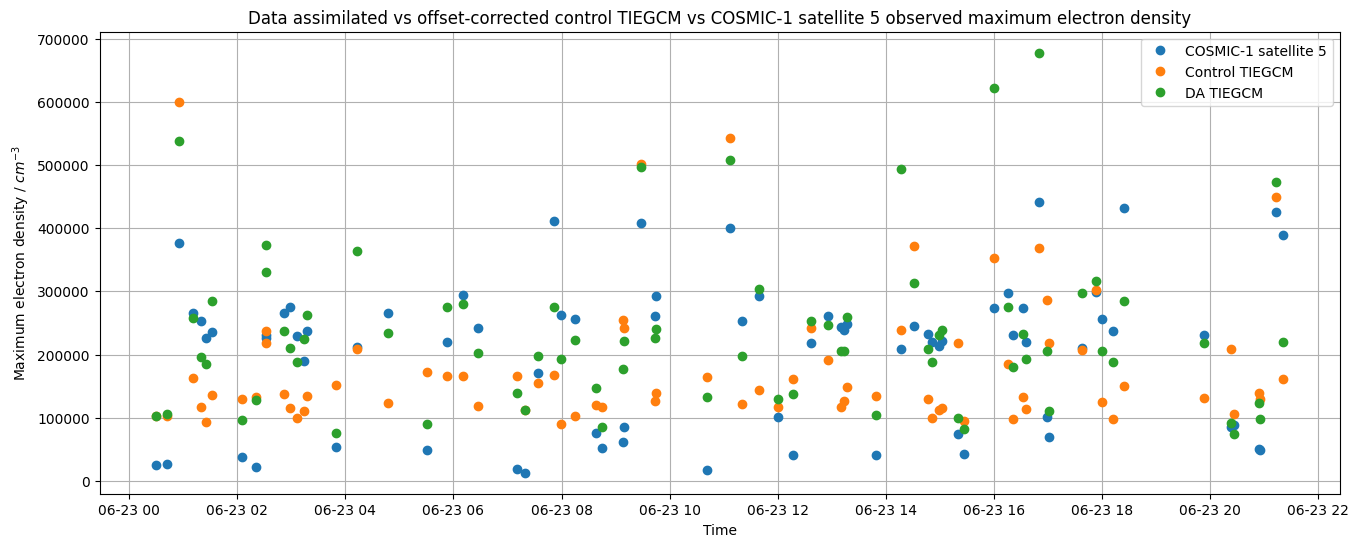

In [47]:
# OFFSET CALCULATION
offset = control_ne[0] - ose_ne[0]
print(offset)
plt.figure(figsize=(16,6))
plt.plot(time, cosmic_ne, 'o', label='COSMIC-1 satellite 5') # satellite 1
plt.plot(time, np.array(control_ne)-offset, 'o', label='Control TIEGCM')
plt.plot(time, ose_ne, 'o', label='DA TIEGCM')
plt.xlabel('Time')
plt.ylabel('Maximum electron density / $cm^{-3}$')
plt.title('Data assimilated vs offset-corrected control TIEGCM vs COSMIC-1 satellite 5 observed maximum electron density')
plt.legend()
plt.grid(True)
plt.show()

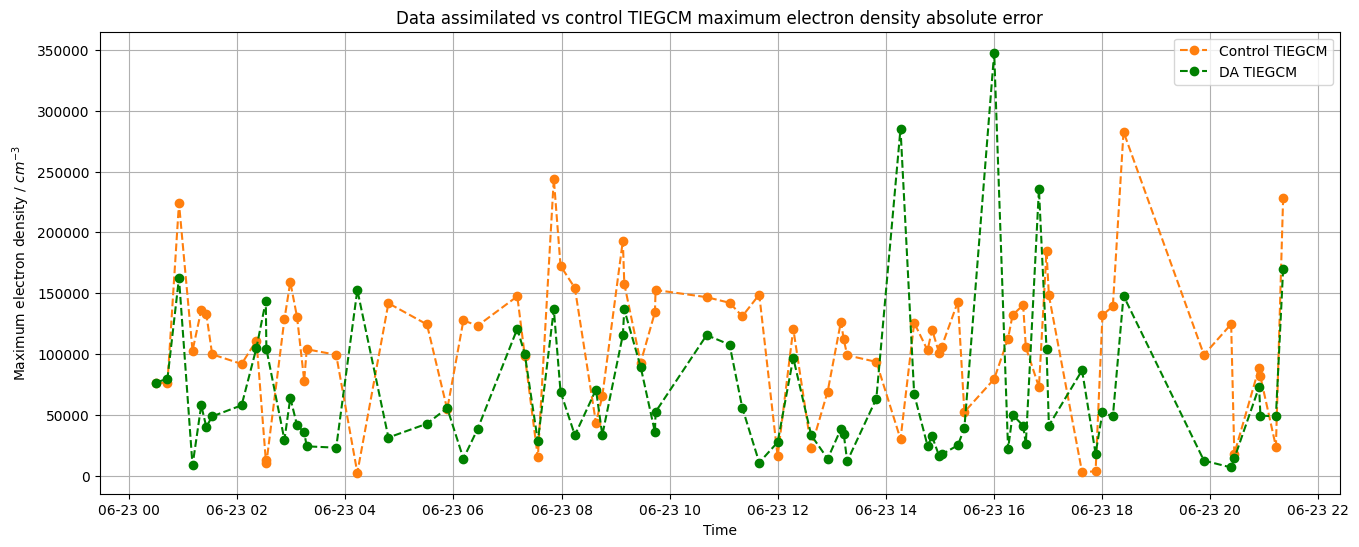

2008-06-23 00:29:43
108282.67385128456
68007.63687000233


In [48]:
# ERROR
plt.figure(figsize=(16,6))
#plt.plot(time, cosmic_ne, 'o', label='COSMIC-1 satellite 1') # satellite 1
plt.plot(time, abs((np.array(control_ne)-offset) - np.array(cosmic_ne)), 'o--', color='tab:orange', label='Control TIEGCM')
plt.plot(time, abs(np.array(ose_ne) - np.array(cosmic_ne)), 'go--', label='DA TIEGCM')
plt.xlabel('Time')
plt.ylabel('Maximum electron density / $cm^{-3}$')
plt.title('Data assimilated vs control TIEGCM maximum electron density absolute error')
plt.legend()
plt.grid(True)
plt.show()
print(time[0])
print(np.mean(abs((np.array(control_ne)-offset) - np.array(cosmic_ne))))
print(np.mean(abs(np.array(ose_ne) - np.array(cosmic_ne))))

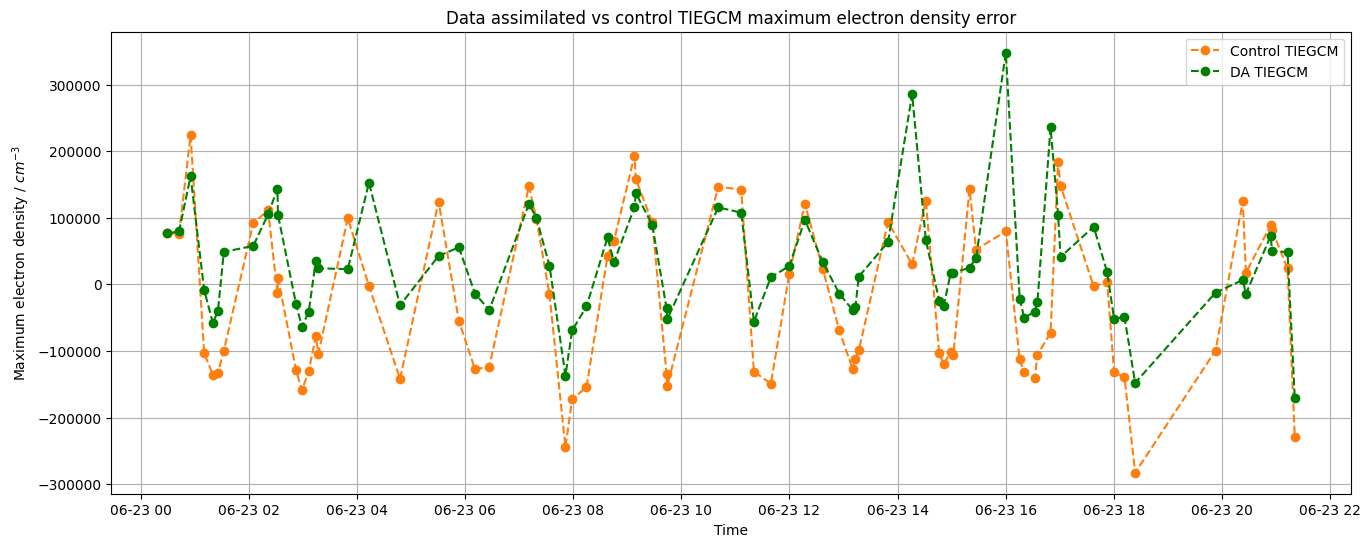

2008-06-23 00:29:43
-22551.778916745996
30251.244943499583


In [49]:
# ERROR
plt.figure(figsize=(16,6))
#plt.plot(time, cosmic_ne, 'o', label='COSMIC-1 satellite 1') # satellite 1
plt.plot(time, ((np.array(control_ne)-offset) - np.array(cosmic_ne)), 'o--', color='tab:orange', label='Control TIEGCM')
plt.plot(time, (np.array(ose_ne) - np.array(cosmic_ne)), 'go--', label='DA TIEGCM')
plt.xlabel('Time')
plt.ylabel('Maximum electron density / $cm^{-3}$')
plt.title('Data assimilated vs control TIEGCM maximum electron density error')
plt.legend()
plt.grid(True)
plt.show()
print(time[0])
print(np.mean(((np.array(control_ne)-offset) - np.array(cosmic_ne))))
print(np.mean((np.array(ose_ne) - np.array(cosmic_ne))))

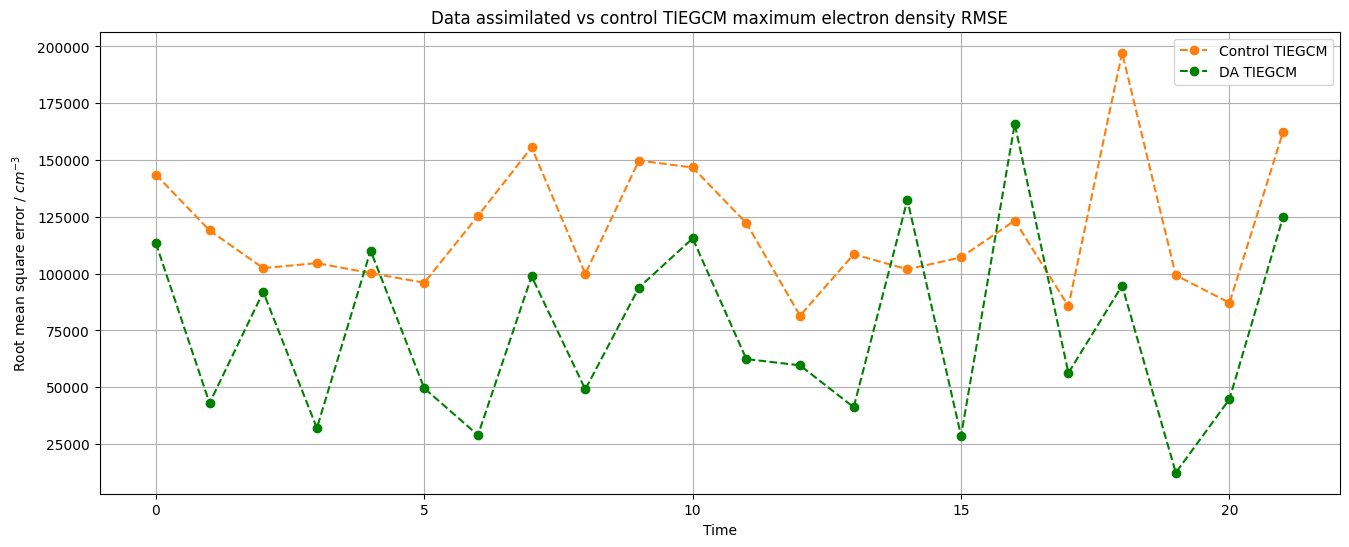

119089.48355432885
74989.9351125097


In [50]:
# RMSE
plt.figure(figsize=(16,6))
plt.plot(np.arange(0,24,1), RMSE_control_ne, 'o--', color='tab:orange', label='Control TIEGCM')
plt.plot(np.arange(0,24,1), RMSE_ose_ne, 'go--', label='DA TIEGCM')
plt.xlabel('Time')
plt.ylabel('Root mean square error / $cm^{-3}$')
plt.title('Data assimilated vs control TIEGCM maximum electron density RMSE')
plt.legend()
plt.grid(True)
plt.show()
print(np.nanmean(RMSE_control_ne))
print(np.nanmean(RMSE_ose_ne))

In [16]:
# DENSITY
def compare_density(tiegcm, hour):
  '''Inputs: tiegcm    = 'ose', 'control'
             hour      = '00' - '23'
  '''
  champ = cdflib.CDF('/content/gdrive/MyDrive/msci_satellite_data/champ/CH_OPER_DNS_ACC_2__20080623T000000_20080623T235959_0001.cdf')
  grace = cdflib.CDF('/content/gdrive/MyDrive/msci_satellite_data/grace/GR_OPER_DNS1ACC_2__20080623T000000_20080623T235959_0001.cdf')
  champ_time = cdflib.cdfepoch.to_datetime(champ.varget('time'))
  grace_time = cdflib.cdfepoch.to_datetime(grace.varget('time'))

  champ_interpolated_densities = [] # TIEGCM densities interpolated to the 3D satellite positions
  grace_interpolated_densities = []

  if tiegcm=='control':
    latA, lonA, ZGA, DENA, NEA, latB, lonB, ZGB, DENB, NEB, latC, lonC, ZGC, DENC, NEC = nasa(hour)

    zero_index = 360*int(hour)
    twenty_index = 360*int(hour) + (6*20)
    forty_index = 360*int(hour) + (6*40)

    interp1 = RegularGridInterpolator((ZGA[:,0,0]*1000,latA,lonA), DENA)
    interp2 = RegularGridInterpolator((ZGB[:,0,0]*1000,latB,lonB), DENB)
    interp3 = RegularGridInterpolator((ZGC[:,0,0]*1000,latC,lonC), DENC)

    for i in np.arange(zero_index, twenty_index, 1):
        champ_alt = min(ZGA[:,0,0]*1000) if champ.varget('altitude')[i] < min(ZGA[:,0,0]*1000) else (max(ZGA[:,0,0]*1000) if champ.varget('altitude')[i] > max(ZGA[:,0,0]*1000) else champ.varget('altitude')[i])
        champ_lat = min(latA) if champ.varget('latitude')[i] < min(latA) else (max(latA) if champ.varget('latitude')[i] > max(latA) else champ.varget('latitude')[i])
        champ_lon = min(lonA) if champ.varget('longitude')[i] < min(lonA) else (max(lonA) if champ.varget('longitude')[i] > max(lonA) else champ.varget('longitude')[i])
        grace_alt = min(ZGA[:,0,0]*1000) if grace.varget('altitude')[i] < min(ZGA[:,0,0]*1000) else (max(ZGA[:,0,0]*1000) if grace.varget('altitude')[i] > max(ZGA[:,0,0]*1000) else grace.varget('altitude')[i])
        grace_lat = min(latA) if grace.varget('latitude')[i] < min(latA) else (max(latA) if grace.varget('latitude')[i] > max(latA) else grace.varget('latitude')[i])
        grace_lon = min(lonA) if grace.varget('longitude')[i] < min(lonA) else (max(lonA) if grace.varget('longitude')[i] > max(lonA) else grace.varget('longitude')[i])
        champ_interpolated_densities.append(interp1((champ_alt, champ_lat, champ_lon)))
        grace_interpolated_densities.append(interp1((grace_alt, grace_lat, grace_lon)))
    for i in np.arange(twenty_index, forty_index, 1):
        champ_alt = min(ZGB[:,0,0]*1000) if champ.varget('altitude')[i] < min(ZGB[:,0,0]*1000) else (max(ZGB[:,0,0]*1000) if champ.varget('altitude')[i] > max(ZGB[:,0,0]*1000) else champ.varget('altitude')[i])
        champ_lat = min(latB) if champ.varget('latitude')[i] < min(latB) else (max(latB) if champ.varget('latitude')[i] > max(latB) else champ.varget('latitude')[i])
        champ_lon = min(lonB) if champ.varget('longitude')[i] < min(lonB) else (max(lonB) if champ.varget('longitude')[i] > max(lonB) else champ.varget('longitude')[i])
        grace_alt = min(ZGB[:,0,0]*1000) if grace.varget('altitude')[i] < min(ZGB[:,0,0]*1000) else (max(ZGB[:,0,0]*1000) if grace.varget('altitude')[i] > max(ZGB[:,0,0]*1000) else grace.varget('altitude')[i])
        grace_lat = min(latB) if grace.varget('latitude')[i] < min(latB) else (max(latB) if grace.varget('latitude')[i] > max(latB) else grace.varget('latitude')[i])
        grace_lon = min(lonB) if grace.varget('longitude')[i] < min(lonB) else (max(lonB) if grace.varget('longitude')[i] > max(lonB) else grace.varget('longitude')[i])
        champ_interpolated_densities.append(interp1((champ_alt, champ_lat, champ_lon)))
        grace_interpolated_densities.append(interp1((grace_alt, grace_lat, grace_lon)))
    for i in np.arange(forty_index, zero_index+360, 1):
        champ_alt = min(ZGC[:,0,0]*1000) if champ.varget('altitude')[i] < min(ZGC[:,0,0]*1000) else (max(ZGC[:,0,0]*1000) if champ.varget('altitude')[i] > max(ZGC[:,0,0]*1000) else champ.varget('altitude')[i])
        champ_lat = min(latC) if champ.varget('latitude')[i] < min(latC) else (max(latC) if champ.varget('latitude')[i] > max(latC) else champ.varget('latitude')[i])
        champ_lon = min(lonC) if champ.varget('longitude')[i] < min(lonC) else (max(lonC) if champ.varget('longitude')[i] > max(lonC) else champ.varget('longitude')[i])
        grace_alt = min(ZGC[:,0,0]*1000) if grace.varget('altitude')[i] < min(ZGC[:,0,0]*1000) else (max(ZGC[:,0,0]*1000) if grace.varget('altitude')[i] > max(ZGC[:,0,0]*1000) else grace.varget('altitude')[i])
        grace_lat = min(latC) if grace.varget('latitude')[i] < min(latC) else (max(latC) if grace.varget('latitude')[i] > max(latC) else grace.varget('latitude')[i])
        grace_lon = min(lonC) if grace.varget('longitude')[i] < min(lonC) else (max(lonC) if grace.varget('longitude')[i] > max(lonC) else grace.varget('longitude')[i])
        champ_interpolated_densities.append(interp1((champ_alt, champ_lat, champ_lon)))
        grace_interpolated_densities.append(interp1((grace_alt, grace_lat, grace_lon)))

  if tiegcm=='ose':
    ds = xr.open_dataset('/content/gdrive/MyDrive/msci_satellite_data/matsuo_tiegcm_ose/tiegcm_s_ensmean.nc.'+f'{hour}')
    if time=='00':
      lat, lon, ZG, DEN, NE = extract(ds, 16, 'ZG')
    else:
      lat, lon, ZG, DEN, NE = extract(ds, 1, 'ZG')

    initial_time_index = 360*int(hour)
    interp4 = RegularGridInterpolator((ZG[:,0,0]*1000,lat,lon), DEN)
    for i in np.arange(initial_time_index, initial_time_index+360, 1):
        champ_alt = min(ZG[:,0,0]*1000) if champ.varget('altitude')[i] < min(ZG[:,0,0]*1000) else (max(ZG[:,0,0]*1000) if champ.varget('altitude')[i] > max(ZG[:,0,0]*1000) else champ.varget('altitude')[i])
        champ_lat = min(lat) if champ.varget('latitude')[i] < min(lat) else (max(lat) if champ.varget('latitude')[i] > max(lat) else champ.varget('latitude')[i])
        champ_lon = min(lon) if champ.varget('longitude')[i] < min(lon) else (max(lon) if champ.varget('longitude')[i] > max(lon) else champ.varget('longitude')[i])
        grace_alt = min(ZG[:,0,0]*1000) if grace.varget('altitude')[i] < min(ZG[:,0,0]*1000) else (max(ZG[:,0,0]*1000) if grace.varget('altitude')[i] > max(ZG[:,0,0]*1000) else grace.varget('altitude')[i])
        grace_lat = min(lat) if grace.varget('latitude')[i] < min(lat) else (max(lat) if grace.varget('latitude')[i] > max(lat) else grace.varget('latitude')[i])
        grace_lon = min(lon) if grace.varget('longitude')[i] < min(lon) else (max(lon) if grace.varget('longitude')[i] > max(lon) else grace.varget('longitude')[i])
        champ_interpolated_densities.append(interp4((champ_alt, champ_lat, champ_lon)))
        grace_interpolated_densities.append(interp4((grace_alt, grace_lat, grace_lon)))

  return champ_interpolated_densities, grace_interpolated_densities

In [17]:
a, b = compare_density('control', '18')
np.array(b).shape

ValueError: One of the requested xi is out of bounds in dimension 0

In [ ]:
champ = cdflib.CDF('/content/gdrive/MyDrive/msci_satellite_data/champ/CH_OPER_DNS_ACC_2__20080623T000000_20080623T235959_0001.cdf')
grace = cdflib.CDF('/content/gdrive/MyDrive/msci_satellite_data/grace/GR_OPER_DNS1ACC_2__20080623T000000_20080623T235959_0001.cdf')
champ_time = cdflib.cdfepoch.to_datetime(champ.varget('time'))
grace_time = cdflib.cdfepoch.to_datetime(grace.varget('time'))

In [ ]:
champ.varget('density')*1000

In [ ]:
plt.plot(champ_time[0:360], np.array(a)*0.001)
#plt.plot(champ_time[:], champ.varget('density')[:])